# Summary

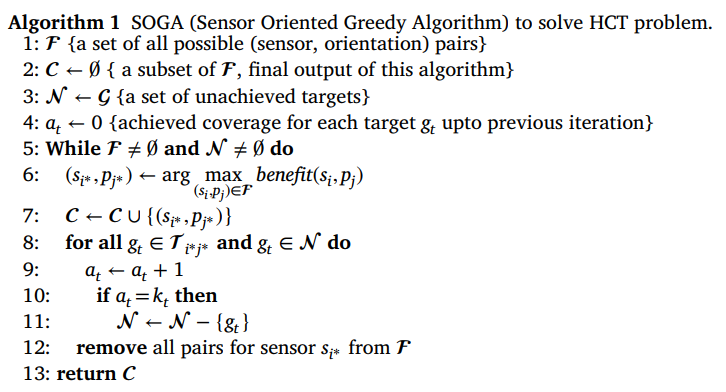

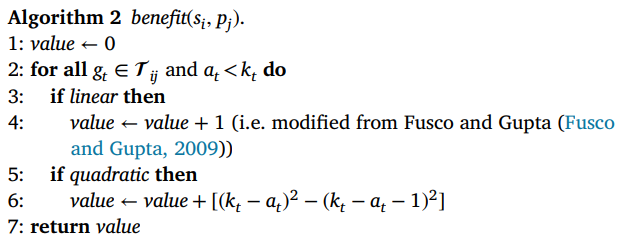

# Implementation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches as ptc
import tqdm


## Data

In [ ]:
def center_square(area):
    x_ = area[0]
    y_ = area[1]
    x_range = x_[1] - x_[0]
    y_range = y_[1] - y_[0]

    x = (x_[0] + x_range*0.25, x_[0] + x_range*0.75)
    y = (y_[0] + y_range*0.25, y_[0] + y_range*0.75)
    return (x, y)

def zipf(n, area):
    n_in = int(0.75*n)
    n_out = n - n_in

    points_out = np.random.rand(2, n_out)

    # map x and y values between minx - maxx, miny - maxy
    points_out[0, :] = np.interp(points_out[0, :], [0, 1], area[0])
    points_out[1, :] = np.interp(points_out[1, :], [0, 1], area[1])

    area_in = center_square(area)
    points_in = np.random.rand(2, n_in)

    # map x and y values between minx - maxx, miny - maxy
    points_in[0, :] = np.interp(points_in[0, :], [0, 1], area_in[0])
    points_in[1, :] = np.interp(points_in[1, :], [0, 1], area_in[1])

    points = np.concatenate((points_out, points_in), axis=1).T
    indices = np.arange(n)
    np.random.shuffle(indices)
    return points[indices]

In [ ]:
def random_points(n_points, area, distribution_type='uniform'):
  pt1, pt2 = area
  if distribution_type == 'uniform':
    # random values between 0 - 1
    points = np.random.rand(2, n_points)

    # map x and y values between minx - maxx, miny - maxy
    points[0, :] = np.interp(points[0, :], [0, 1], area[0])
    points[1, :] = np.interp(points[1, :], [0, 1], area[1])

    return points.T

  if distribution_type == 'zipf':
    points = zipf(n_points, area)

  return points

def generate_data(distribution_type='uniform'):
  sensing_radius = 20
  # Fixed_sensors
  fs_data = {'small': [], 'large': []}
  # small
  n = 30
  area = ((0, 200), (0, 200))
  sensors = random_points(n, area, distribution_type=distribution_type)
  targets_all = random_points(120, area)
  K_all = np.random.randint(low=1, high=4, size=120)
  for i in range(3, 121):
    targets = targets_all[:i]
    K = list(K_all[:i])
    fs_data['small'].append({'m' : i,
          'n' : n,
          'q' : 8,
          'K' : list(map(int, K)),
          'radius' : sensing_radius,
          'targets' : targets,
          'sensors': sensors,
          'margin': ((-5, 205), (-5, 205))})

  # large
  n = 45
  area = ((0, 1000), (0, 1000))
  sensors = random_points(n, area, distribution_type=distribution_type)
  targets_all = random_points(180, area)
  K_all = np.random.randint(low=1, high=4, size=180)
  for i in range(6, 181):
    targets = targets_all[:i]
    K = list(K_all[:i])
    fs_data['large'].append({'m' : i,
          'n' : n,
          'q' : 8,
          'K' : list(map(int, K)),
          'radius' : sensing_radius,
          'targets' : targets,
          'sensors': sensors,
          'margin': ((-5, 1005), (-5, 1005))})

  # Fixed_targets
  ft_data = {'small': [], 'large': []}
  # small
  m = 30
  area = ((0, 200), (0, 200))
  targets = random_points(m, area)
  sensors_all = random_points(120, area, distribution_type=distribution_type)
  K = list(np.random.randint(low=1, high=4, size=m))
  for i in range(3, 121):
    sensors = sensors_all[:i]
    ft_data['small'].append({'m' : m,
          'n' : i,
          'q' : 8,
          'K' : list(map(int, K)),
          'radius' : sensing_radius,
          'targets' : targets,
          'sensors': sensors,
          'margin': ((-5, 205), (-5, 205))})

  # large
  m = 45
  area = ((0, 1000), (0, 1000))
  targets = random_points(m, area)
  sensors_all = random_points(180, area, distribution_type=distribution_type)
  K = list(np.random.randint(low=1, high=4, size=m))
  for i in range(6, 181):
    sensors = sensors_all[:i]
    ft_data['large'].append({'m' : m,
          'n' : i,
          'q' : 8,
          'K' : list(map(int, K)),
          'radius' : sensing_radius,
          'targets' : targets,
          'sensors': sensors,
          'margin': ((-5, 1005), (-5, 1005))})

  return {
      'fixed-sensor': fs_data,
      'fixed-target': ft_data,
  }

In [ ]:
data = generate_data()

In [ ]:
sample = data['fixed-sensor']['small'][20]

## Utils

In [ ]:
def make_pan_boundaries(centroid, q, radius):
    # first line always lies on x_axis
    ans = []
    theta = 2*np.pi/q
    for i in range(q):
        x = radius*np.cos(theta*i)
        y = radius*np.sin(theta*i)
        ans.append((centroid[0] + x, centroid[1] + y))

    return ans

In [ ]:
def show_network(network, sensors_mask=None, figsize=None):
    if figsize is not None:
      plt.figure(figsize=(figsize, figsize))

    x_lim = network['margin'][0]
    y_lim = network['margin'][1]

    targets = network['targets']
    sensors = network['sensors']
    radius = network['radius']
    q = network['q']
    tar_x = [i[0] for i in targets]
    tar_y = [i[1] for i in targets]
    plt.plot(tar_x, tar_y, 'r^', label='targets')
    sen_x = [i[0] for i in sensors]
    sen_y = [i[1] for i in sensors]
    plt.plot(sen_x, sen_y, 'go', label='sensors')
    ax = plt.gca()

    for i in range(len(sensors)):
        sensor = sensors[i]
        active = True

        if sensors_mask is not None:
            active = False
            theta = 360.0/q
            pj = sensors_mask[i]
            if pj is not None:
              active = True
              theta1, theta2 = theta*pj, theta*(pj+1)
              wedge = ptc.Wedge(sensors[i], radius, theta1, theta2, color='#34e1eb', alpha=0.45)
              ax.add_artist(wedge)
        if active:
          # if sensors_mask is not None:
          #   plt.annotate(f's{i}', sensors[i], textcoords='offset points', xytext=(0, 5), ha='center')
          circle = plt.Circle(sensor, radius, color='m', fill=False, linewidth=1)
          ax.add_artist(circle)
          pan_boundaries = make_pan_boundaries(sensor, q, radius)
          for point in pan_boundaries:
              plt.plot([sensor[0], point[0]], [sensor[1], point[1]], 'b--', alpha=0.2)

    plt.xlim([x_lim[0], x_lim[1]])
    plt.ylim([y_lim[0], y_lim[1]])
    ax.set_aspect(1.0)  # make aspect ratio square

    plt.legend()

    plt.show()

In [ ]:
def is_within_FoV(bisector, target, sensor, radius):
    target = np.asarray(target)
    sensor = np.asarray(sensor)
    bisector = np.asarray(bisector)
    v = target - sensor
    dist = np.linalg.norm(v)
    scalar = bisector.dot(v)
    return scalar + 1e-7 >= radius*dist*np.cos(np.pi/8) and dist - 1e-7 <= radius

def mask_T(m, n, q, radius, targets, sensors):
  T = np.zeros((n, q), dtype=list)
  for i in range(n):
    for j in range(q):
      T[i, j] = []

  bisectors = []
  for i in range(8):
    bisectors.append((radius*np.cos(np.pi/8+i*np.pi/4), radius*np.sin(np.pi/8+i*np.pi/4)))

  for i in range(m):
    for j in range(n):
      for k in range(q):
        if is_within_FoV(bisectors[k], targets[i], sensors[j], radius):
          T[j, k].append(i)

  return T


## Visualize sample

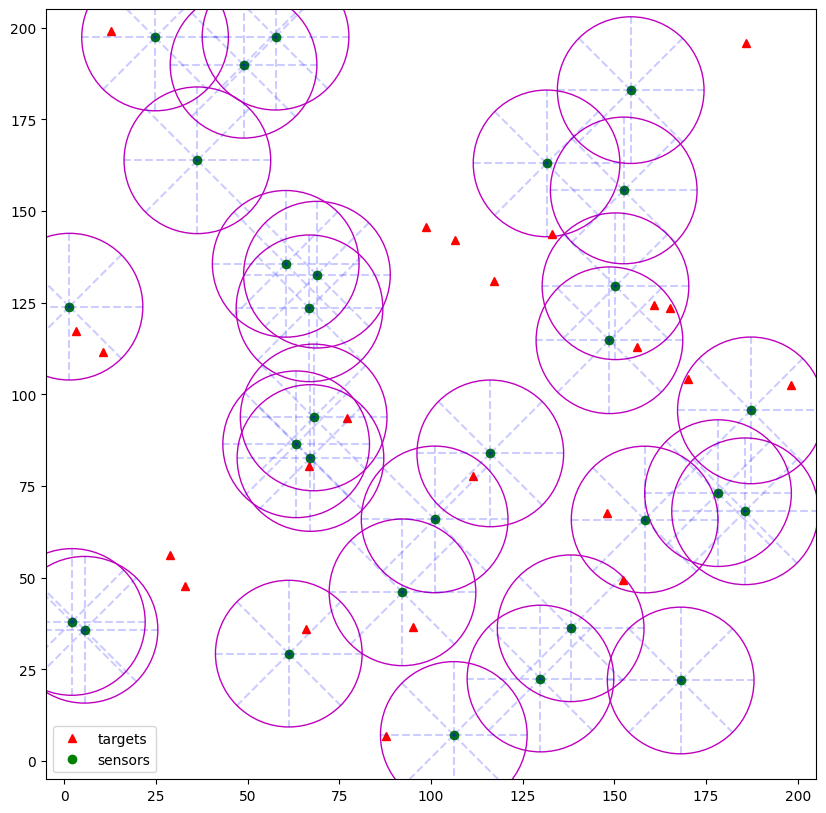

In [ ]:
show_network(sample, figsize=10)

## Sensor Oriented Greedy Algorithm

In [ ]:
def add_method(cls):
    def inner(func):
        setattr(cls, func.__name__, func)
    return inner

In [ ]:
class SOGA:
  def __init__(self, n_targets, n_sensors, n_pans=8):
    self.n_targets = n_targets
    self.n_sensors = n_sensors
    self.n_pans = n_pans
    self.__build()

  def __build(self):
    self.F = [None]*self.n_sensors
    for i in range(self.n_sensors):
      self.F[i] = list(range(self.n_pans))

    self.N = set(range(self.n_targets))


Define 'solve' method

In [ ]:
@add_method(SOGA)
def solve(self, K, T, mode="linear"):
  F = self.F.copy()
  N = self.N.copy()
  C = [None]*self.n_sensors
  a = np.zeros((self.n_targets,))

  while self.__continue(F, N, T):

    _, si, pj = self.__max_benefit(F=F, T=T, a=a, K=K, mode=mode)
    if si is None or pj is None:
      continue
    C[si] = pj
    for t in T[si, pj]:
      if t in N:
        a[t] += 1
        if a[t] == K[t]:
          N.remove(t)
    F[si] = None

  return C, a


Add required methods for 'solve'

In [ ]:
@add_method(SOGA)
def __max_benefit(self, F, T, a, K, mode):
  si_ = None
  pj_ = None
  value_ = -1

  for i in range(len(F)):
    if F[i] == None:
      continue
    # print(F[i])
    for j in F[i]:
      value = 0
      flag = False
      for t in T[i, j]:
        if a[t] < K[t]:
          flag = True
          if mode == 'linear':
            value += 1
          elif mode == 'quadratic':
            value += ((K[t] - a[t])**2 - (K[t] - a[t] - 1)**2)
          elif mode == 'prioritize':
            value += K[t]*((K[t] - a[t])**2 - (K[t] - a[t] - 1)**2)
          elif mode == 'reduced_variance':
            count = 0
            group_achived_coverage = 0
            for t_i in range(len(K)):
              if K[t_i] == K[t]:
                count += 1
                group_achived_coverage += a[t_i]
            u, g = group_achived_coverage/count, count
            old = (K[t]-a[t])**2 + (a[t]-u)**2/g
            new = (K[t]-a[t]-1)**2 + (a[t]-u+1-1/g)**2/g
            value += old-new
      if flag and (value > value_):
        value_ = value
        si_ = i
        pj_ = j

  return value_, si_, pj_


In [ ]:
@add_method(SOGA)
def __remain(self, F, N, T):
  for i in range(len(F)):
    if F[i] is not None:
      for j in F[i]:
        for t in T[i, j]:
          if t in N:
            return True
  return False

@add_method(SOGA)
def __continue(self, F, N, T):
  return (len(N) >= 0) and any(F) and self.__remain(F, N, T)


In [ ]:
def solve_SOGA(network, mode='linear'):
  m = network['m']    # number of targets
  n = network['n']    # number of sensors
  q = network['q']    # number of pans
  targets = network['targets']
  sensors = network['sensors']
  radius = network['radius']
  K = np.asarray(network['K'])

  T = mask_T(m, n, q, radius, targets, sensors)

  model = SOGA(m, n, q)
  sensors_mask, achieved_coverage = model.solve(K, T, mode=mode)

  return achieved_coverage, sensors_mask


## Solve

In [ ]:
achieved_coverage, sensors_mask = solve_SOGA(sample)

In [ ]:
print("expected: ", sample['K'])
print("actual: ", achieved_coverage)

expected:  [3, 3, 2, 1, 2, 2, 1, 3, 2, 1, 3, 1, 2, 2, 1, 1, 1, 3, 1, 1, 1, 1, 3]
actual:  [1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0.]


In [ ]:
sensors_mask

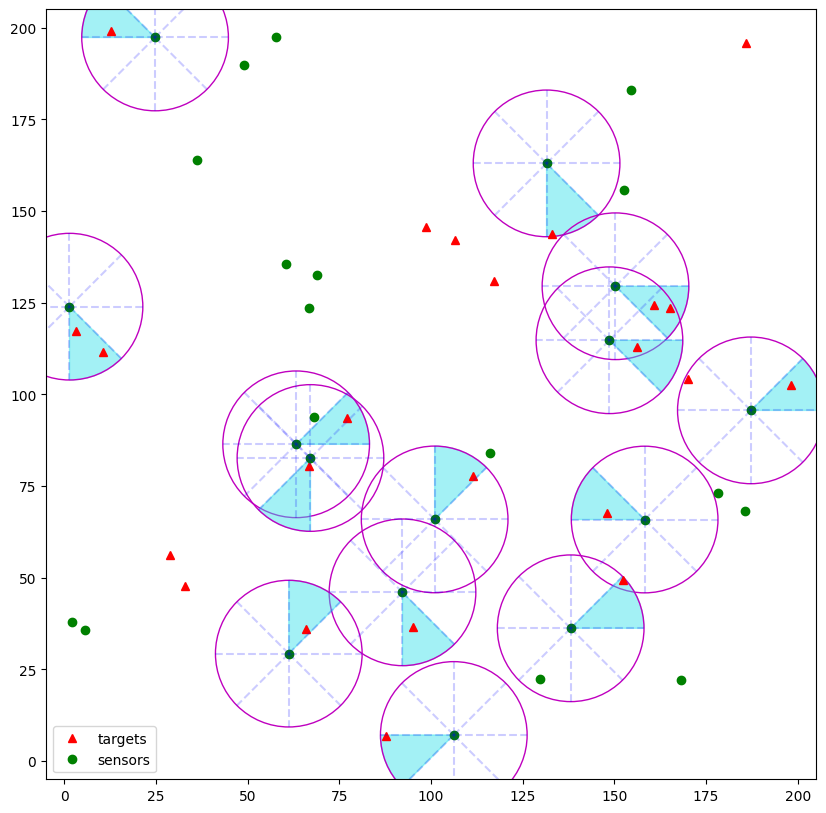

In [ ]:
show_network(sample, sensors_mask, figsize=10)

# Metrics

## Distance index

In [ ]:
def distance_index(k, x):
  k = np.asarray(k)
  x = np.asarray(x)

  a = np.sum(k*k)
  b = k - x
  b = np.sum(b*b)
  return (a-b)/a


## Variance

In [ ]:
def variance(k, x):
  k = np.asarray(k)
  x = np.asarray(x)
  m = x.shape[0]
  mk = np.zeros_like(x)
  for t in range(m):
    mk[t] = np.sum(k == k[t])
  nu_k = np.zeros_like(x)
  for t in range(m):
    ans = 0
    for i in range(m):
      ans += x[i]*(k[i] == k[t])
    nu_k[t] = ans/mk[t]

  a = (x - nu_k)
  return np.sum(a*a/mk)

## Activated sensor

In [ ]:
def activated_sensors(mask):
  cnt = 0
  for i in mask:
    if i is not None:
      cnt += 1

  return cnt

# Evaluate

In [ ]:
eval_data = generate_data()

## Fixed sensor

In [ ]:
small_fs = eval_data['fixed-sensor']['small']


### Distance index

In [ ]:
DIs_fs_small = []
for dt in tqdm.tqdm(small_fs):
  achieved_coverage, _ = solve_SOGA(dt)
  DI_score = distance_index(np.asarray(dt['K']), achieved_coverage)
  DIs_fs_small.append(DI_score)

100%|██████████| 118/118 [00:23<00:00,  4.92it/s]


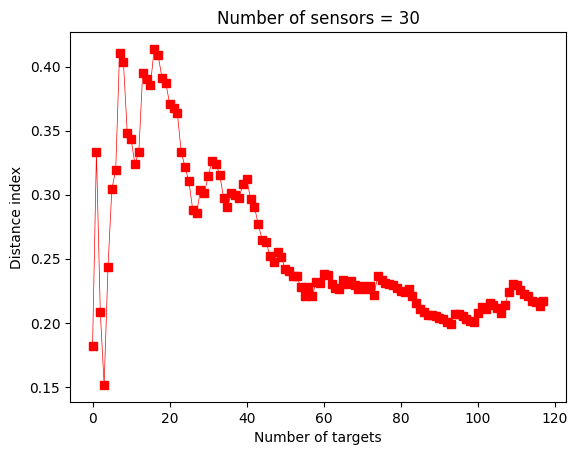

In [ ]:
x_axis = np.arange(len(small_fs))
plt.plot(x_axis, DIs_fs_small, 'r-', linewidth=0.5)
plt.plot(x_axis, DIs_fs_small, 'rs')
plt.xlabel("Number of targets")
plt.ylabel("Distance index")
plt.title(f'Number of sensors = {small_fs[0]["n"]}')
plt.show()

### Variance

In [ ]:
VARs_fs_small = []
for dt in tqdm.tqdm(small_fs):
  achieved_coverage, _ = solve_SOGA(dt)
  var_score = variance(np.asarray(dt['K']), achieved_coverage)
  VARs_fs_small.append(var_score)

100%|██████████| 118/118 [00:24<00:00,  4.90it/s]


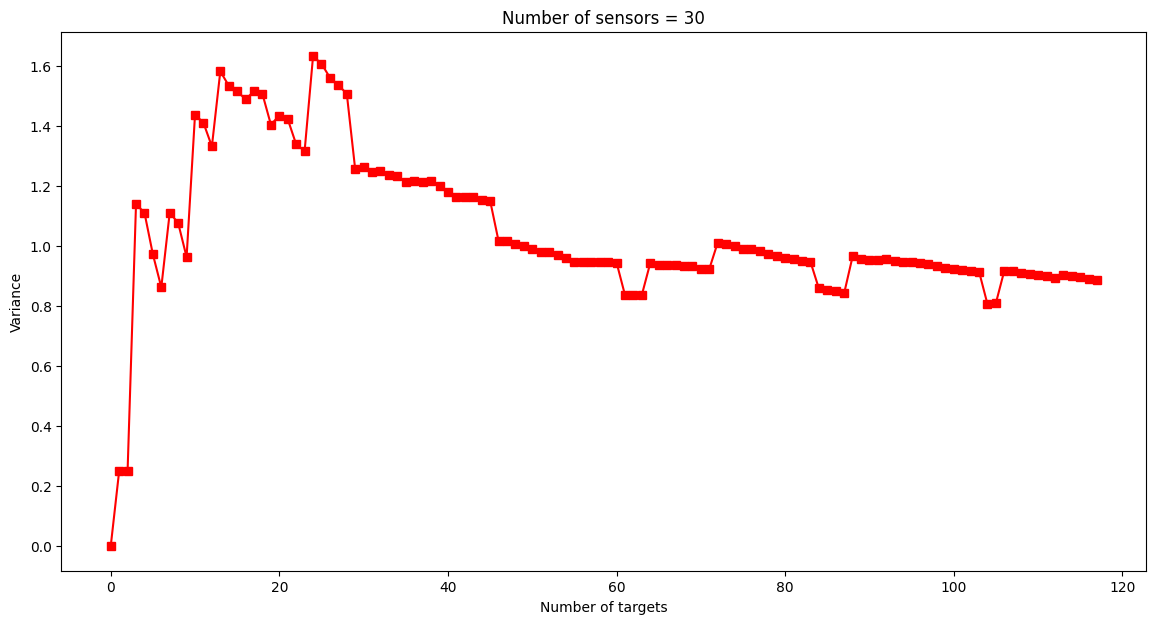

In [ ]:
plt.figure(figsize=(14, 7))
x_axis = np.arange(len(small_fs))
plt.plot(x_axis, VARs_fs_small, 'r-')
plt.plot(x_axis, VARs_fs_small, 'rs')
plt.xlabel("Number of targets")
plt.ylabel("Variance")
plt.title(f'Number of sensors = {small_fs[0]["n"]}')
plt.show()

### Activated sensors

In [ ]:
ACT_fs_small = []
for dt in tqdm.tqdm(small_fs):
  _, mask = solve_SOGA(dt)
  act_score = activated_sensors(mask)
  ACT_fs_small.append(act_score)

100%|██████████| 118/118 [00:19<00:00,  6.10it/s]


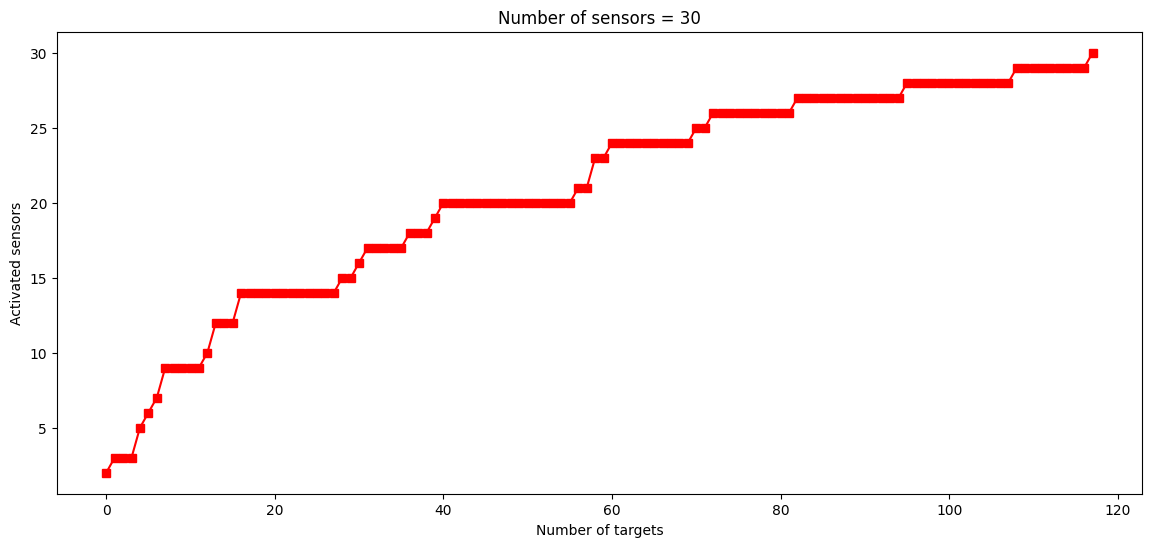

In [ ]:
plt.figure(figsize=(14, 6))
x_axis = np.arange(len(small_fs))
plt.plot(x_axis, ACT_fs_small, 'r-')
plt.plot(x_axis, ACT_fs_small, 'rs')
plt.xlabel("Number of targets")
plt.ylabel("Activated sensors")
plt.title(f'Number of sensors = {small_fs[0]["n"]}')
plt.show()

## Fixed target

In [ ]:
small_ft = eval_data['fixed-target']['small']


### Distance index

In [ ]:
DIs_ft_small = []
for dt in tqdm.tqdm(small_ft):
  achieved_coverage, _ = solve_SOGA(dt)
  DI_score = distance_index(np.asarray(dt['K']), achieved_coverage)
  DIs_ft_small.append(DI_score)


100%|██████████| 118/118 [00:18<00:00,  6.45it/s]


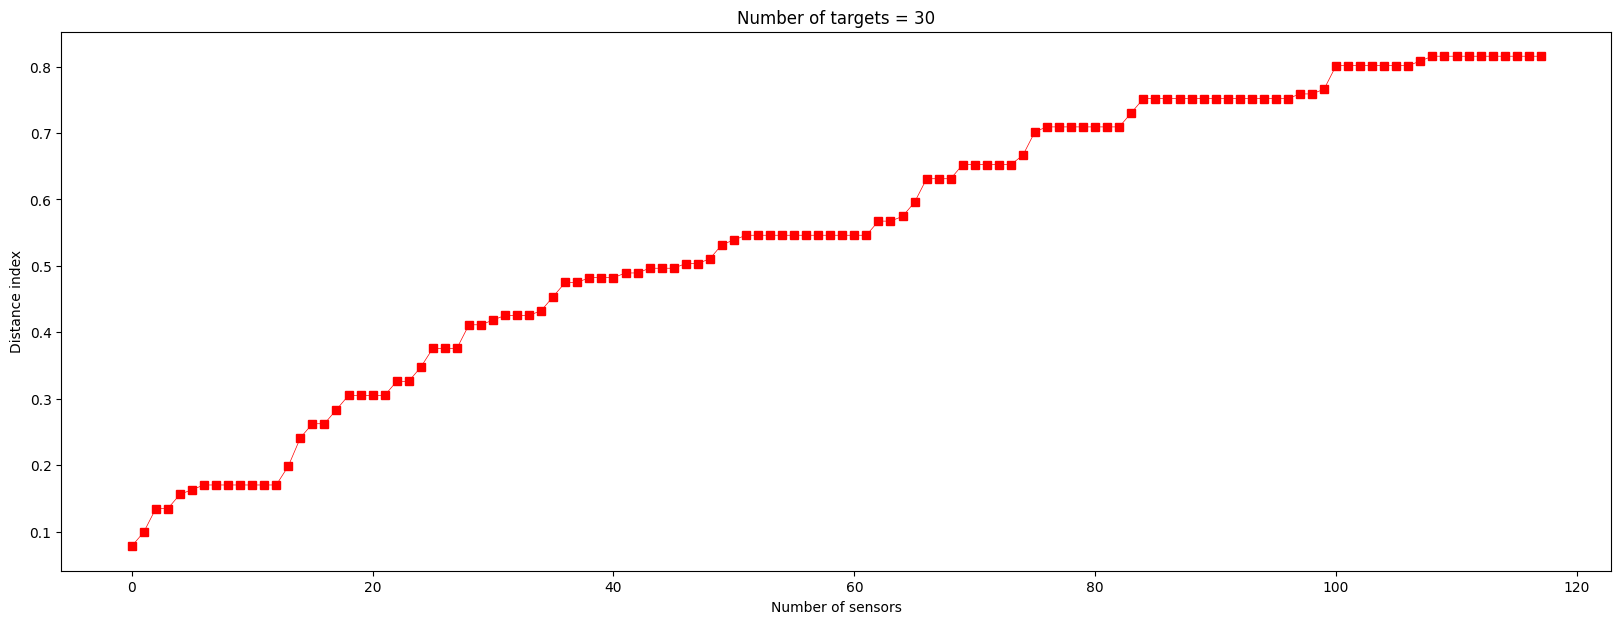

In [ ]:
plt.figure(figsize=(20, 7))
x_axis = np.arange(len(small_ft))
plt.plot(x_axis, DIs_ft_small, 'r-', linewidth=0.5)
plt.plot(x_axis, DIs_ft_small, 'rs')
plt.xlabel("Number of sensors")
plt.ylabel("Distance index")
plt.title(f'Number of targets = {small_ft[0]["m"]}')
plt.show()

### Variance

In [ ]:
VARs_ft_small = []
for dt in tqdm.tqdm(small_ft):
  achieved_coverage, _ = solve_SOGA(dt)
  var_score = variance(np.asarray(dt['K']), achieved_coverage)
  VARs_ft_small.append(var_score)

100%|██████████| 118/118 [00:20<00:00,  5.90it/s]


In [6]:
plt.figure(figsize=(14, 7))
x_axis = np.arange(len(small_ft))
plt.plot(x_axis, VARs_ft_small, 'r-')
plt.plot(x_axis, VARs_ft_small, 'rs')
plt.xlabel("Number of sensors")
plt.ylabel("Variance")
plt.title(f'Number of targets = {small_ft[0]["m"]}')
plt.show()

NameError: ignored

### Activated sensors

In [ ]:
ACT_ft_small = []
for dt in tqdm.tqdm(small_ft):
  _, mask = solve_SOGA(dt)
  act_score = activated_sensors(mask)
  ACT_ft_small.append(act_score)

100%|██████████| 118/118 [00:19<00:00,  5.93it/s]


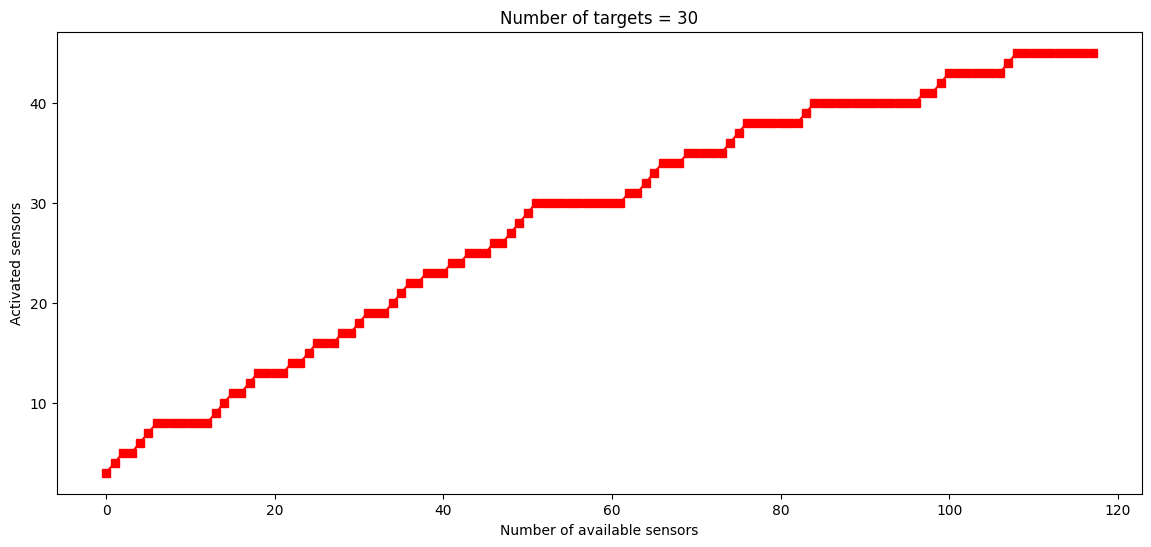

In [ ]:
plt.figure(figsize=(14, 6))
x_axis = np.arange(len(small_ft))
plt.plot(x_axis, ACT_ft_small, 'r-')
plt.plot(x_axis, ACT_ft_small, 'rs')
plt.xlabel("Number of available sensors")
plt.ylabel("Activated sensors")
plt.title(f'Number of targets = {small_ft[0]["m"]}')
plt.show()

In [2]:
import pandas as pd

In [3]:
!gdown 1rtJqFAlDgeQ0mgavwsFLBJlSm0MR9YSF

Downloading...
From: https://drive.google.com/uc?id=1rtJqFAlDgeQ0mgavwsFLBJlSm0MR9YSF
To: /content/Distance_Index_fs.csv
100% 7.12k/7.12k [00:00<00:00, 23.3MB/s]


In [4]:
di_fs = pd.read_csv('/content/Distance_Index_fs.csv')

In [5]:
plt.figure(figsize=(16, 7))
x_axis = np.arange(len(DI_fs_avg))
plt.plot(x_axis, DI_fs_avg, 'r-', linewidth=1.0)
plt.plot(x_axis, DI_fs_avg, 'rs', markersize=4.5, label='GA')

plt.plot(x_axis, di_fs['ILP'], 'g-', linewidth=1.0)
plt.plot(x_axis, di_fs['ILP'], 'go', markersize=4.5, label='ILP')

plt.plot(x_axis, di_fs['IQP'], 'b-', linewidth=1.0)
plt.plot(x_axis, di_fs['IQP'], 'b^', markersize=4.5, label='IQP')

plt.plot(x_axis, di_fs['PIQP'], 'm-', linewidth=1.0)
plt.plot(x_axis, di_fs['PIQP'], 'm*', markersize=4.5, label='PIQP')

plt.xlabel("Number of targets")
plt.ylabel("Distance index")
plt.legend()
plt.show()

NameError: ignored